In [15]:
from datetime import datetime as dt
from datetime import timedelta as td
from math import ceil
from time import sleep

from dydx3 import Client
from dydx3.constants import SYNTHETIC_ASSET_MAP
import pandas as pd

def get_all_dydx_markets():
    all_markets = set(SYNTHETIC_ASSET_MAP.keys())
    valid_markets = all_markets - {
        "TRX-USD", "XTZ-USD", "HNT-USD", "ETC-USD"
    }
    return list(valid_markets)

ALL_MARKETS = get_all_dydx_markets()

c = Client("https://api.dydx.exchange")    

def get_candle_vals(market, start_timestamp, end_timestamp, names=["usdVolume"]):
    max_limit = 100
    num_days = (end_timestamp - start_timestamp)*60*60*24
    num_candles = num_days
    num_iterations = num_candles // max_limit # number of iterations we need to do of data pagination
    
    client = Client(host="https://api.dydx.exchange")
    start = start_timestamp
    all_candles = []
    dfs = []
    while start < dt.now().timestamp():
        end = start + 24*60*60*max_limit # get the number of minutes
        try:
            candles = client.public.get_candles(
                market=market,
                resolution="1DAY",
                from_iso=dt.fromtimestamp(start).isoformat(),
                to_iso=dt.fromtimestamp(end).isoformat()
            ).data["candles"]
            dfs.append(pd.DataFrame(candles).set_index("startedAt"))
        except:
            pass
        finally:
            start = end
            sleep(0.1) # in accord with rate-limiting to 100 requests per 10 seconds
            
    combined_dfs = pd.concat(dfs)
    res = combined_dfs.loc[combined_dfs.index.drop_duplicates(keep='first')][names].sort_index()
#     print("res", res)
    return res

def get_volumes(market, start_timestamp, end_timestamp):
    return get_candle_vals(market, start_timestamp, end_timestamp, names=["usdVolume"])

def get_open_interests(market, start_timestamp, end_timestamp):
    ois, opens = "startingOpenInterest", "open"
    data = get_candle_vals(market, start_timestamp, end_timestamp, names=[ois, opens]).astype(float)
    return data[ois]*data[opens].rename("oi_usd")

e = dt.now().timestamp()
s = e - 60*60*24*30*8

# volumes = pd.DataFrame({
#     mkt: get_volumes(mkt, s, e)
#     for mkt in ALL_MARKETS
# }).astype(float).fillna(0)

open_interests = pd.DataFrame({
    mkt: get_open_interests(mkt, s, e)
    for mkt in ALL_MARKETS
}).astype(float).fillna(0)

In [16]:
# daily_cumulative_volumes = volumes.sum(axis=1); daily_cumulative_volumes

In [17]:
daily_cumulative_open_interests = open_interests.sum(axis=1); daily_cumulative_open_interests

startedAt
2021-07-26T00:00:00.000Z    2.496561e+07
2021-07-27T00:00:00.000Z    2.517315e+07
2021-07-28T00:00:00.000Z    2.622149e+07
2021-07-29T00:00:00.000Z    2.489231e+07
2021-07-30T00:00:00.000Z    2.709073e+07
                                ...     
2022-03-19T00:00:00.000Z    1.072717e+09
2022-03-20T00:00:00.000Z    1.106700e+09
2022-03-21T00:00:00.000Z    1.074611e+09
2022-03-22T00:00:00.000Z    1.085024e+09
2022-03-23T00:00:00.000Z    1.114166e+09
Length: 241, dtype: float64

## Open Interest Investigation

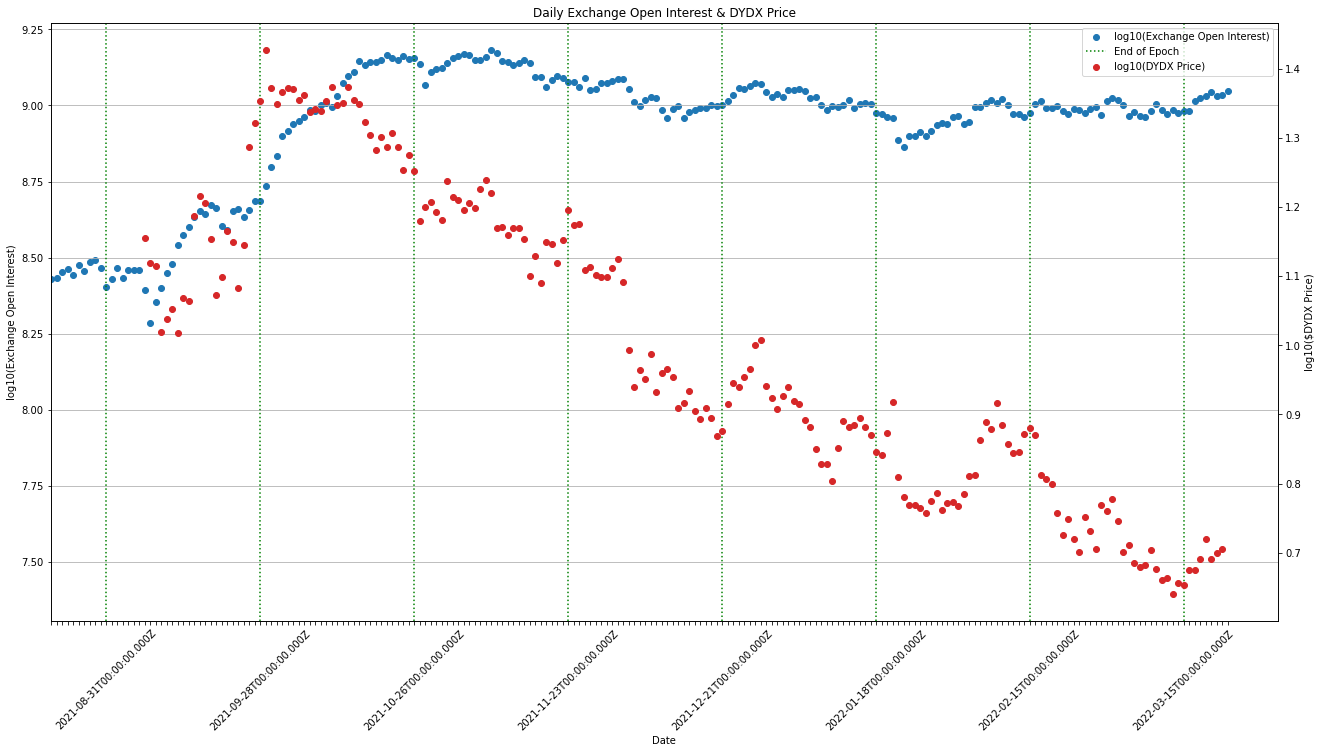

In [21]:
import ccxt
import numpy as np

ftx_client = ccxt.ftx()
start = ftx_client.parse8601('2021-07-22T00:00:00:00.000Z')
ohlcv = np.array(ftx_client.fetch_ohlcv("DYDX/USD", '1d', since=start, limit=1000))
open_dydx_price = ohlcv[:,1]

# convert times to be compatible with 0-based times; this technically messes with the numbers a bit, but not much
price_approx_times = [
    dt(*dt.fromtimestamp(t/1000).timetuple()[:3]).isoformat()+".000Z"
    for t in ohlcv[:,0]
]

dydx_prices_series = pd.Series(
    open_dydx_price, index=price_approx_times
)
# dydx_prices_series.index.values





########## Price Data #############

import matplotlib.pyplot as plt
import numpy as np

# get data
plot_set = daily_cumulative_open_interests

# plot it
_, (ax) = plt.subplots(1, figsize=(22,11))

volumes_plot = ax.scatter(plot_set.index, np.log10(plot_set.values), label="log10(Exchange Open Interest)", color="tab:blue")

plt.title("Daily Exchange Open Interest & DYDX Price")
ax.set_xlabel("Date")
ax.set_ylabel("log10(Exchange Open Interest)")

epoch_end_dates = [
    "2021-08-31T00:00:00.000Z", # end of 0
    "2021-09-28T00:00:00.000Z", # end of 1
    "2021-10-26T00:00:00.000Z", # end of 2
    "2021-11-23T00:00:00.000Z", # end of 3
    "2021-12-21T00:00:00.000Z", # end of 4
    "2022-01-18T00:00:00.000Z", # end of 5
    "2022-02-15T00:00:00.000Z", # end of 6
    "2022-03-15T00:00:00.000Z", # end of 7
]
for epoch_end in epoch_end_dates:
    epoch_end_line = ax.axvline(x=epoch_end, color='g', linestyle=':', label="End of Epoch")

xticks = ax.xaxis.get_major_ticks()
for i, xtick in enumerate(xticks):
#     if i % 5 != 0:
    if plot_set.index[i] not in epoch_end_dates:
        xtick.label1.set_visible(False)
        
        
plt.xticks(rotation=45)
plt.grid(axis="y")
# ax.legend([epoch_end_line, volumes_plot], ['epoch end', 'log-volumes'], loc='upper left')


# Plot price
plot_set_prices = dydx_prices_series.reindex(plot_set.index)
ax2 = ax.twinx()
ax2.set_ylabel("log10($DYDX Price)")
dydx_prices_plot = ax2.scatter(plot_set.index, np.log10(plot_set_prices.values), label="log10(DYDX Price)", color="tab:red")

# Add legend
lns = [volumes_plot, epoch_end_line, dydx_prices_plot]
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper right");



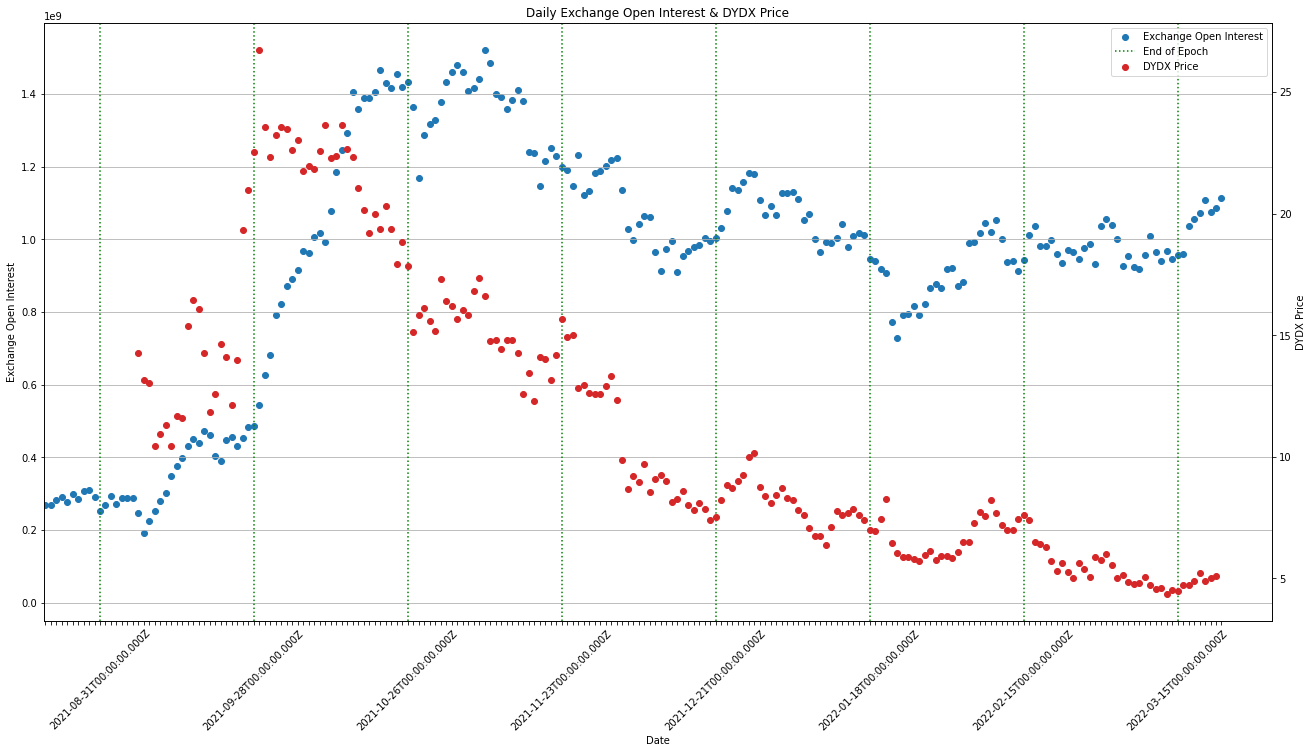

In [22]:
# get data
plot_set = daily_cumulative_open_interests

# plot it
_, (ax) = plt.subplots(1, figsize=(22,11))

volumes_plot = ax.scatter(plot_set.index, plot_set.values, label="Exchange Open Interest", color="tab:blue")

plt.title("Daily Exchange Open Interest & DYDX Price")
ax.set_xlabel("Date")
ax.set_ylabel("Exchange Open Interest")

epoch_end_dates = [
    "2021-08-31T00:00:00.000Z", # end of 0
    "2021-09-28T00:00:00.000Z", # end of 1
    "2021-10-26T00:00:00.000Z", # end of 2
    "2021-11-23T00:00:00.000Z", # end of 3
    "2021-12-21T00:00:00.000Z", # end of 4
    "2022-01-18T00:00:00.000Z", # end of 5
    "2022-02-15T00:00:00.000Z", # end of 6
    "2022-03-15T00:00:00.000Z", # end of 7
]
for epoch_end in epoch_end_dates:
    epoch_end_line = ax.axvline(x=epoch_end, color='g', linestyle=':', label="End of Epoch")

xticks = ax.xaxis.get_major_ticks()
for i, xtick in enumerate(xticks):
#     if i % 5 != 0:
    if plot_set.index[i] not in epoch_end_dates:
        xtick.label1.set_visible(False)
        
        
plt.xticks(rotation=45)
plt.grid(axis="y")
# ax.legend([epoch_end_line, volumes_plot], ['epoch end', 'log-volumes'], loc='upper left')


# Plot price
plot_set_prices = dydx_prices_series.reindex(plot_set.index)
ax2 = ax.twinx()
ax2.set_ylabel("DYDX Price")
dydx_prices_plot = ax2.scatter(plot_set.index, plot_set_prices.values, label="DYDX Price", color="tab:red")

# Add legend
lns = [volumes_plot, epoch_end_line, dydx_prices_plot]
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper right");

## Volume + Price Investigation

In [110]:
import ccxt
import numpy as np

ftx_client = ccxt.ftx()
start = ftx_client.parse8601('2021-07-22T00:00:00:00.000Z')
ohlcv = np.array(ftx_client.fetch_ohlcv("DYDX/USD", '1d', since=start, limit=1000))
open_dydx_price = ohlcv[:,1]

# convert times to be compatible with 0-based times; this technically messes with the numbers a bit, but not much
price_approx_times = [
    dt(*dt.fromtimestamp(t/1000).timetuple()[:3]).isoformat()+".000Z"
    for t in ohlcv[:,0]
]

dydx_prices_series = pd.Series(
    open_dydx_price, index=price_approx_times
)
# dydx_prices_series.index.values

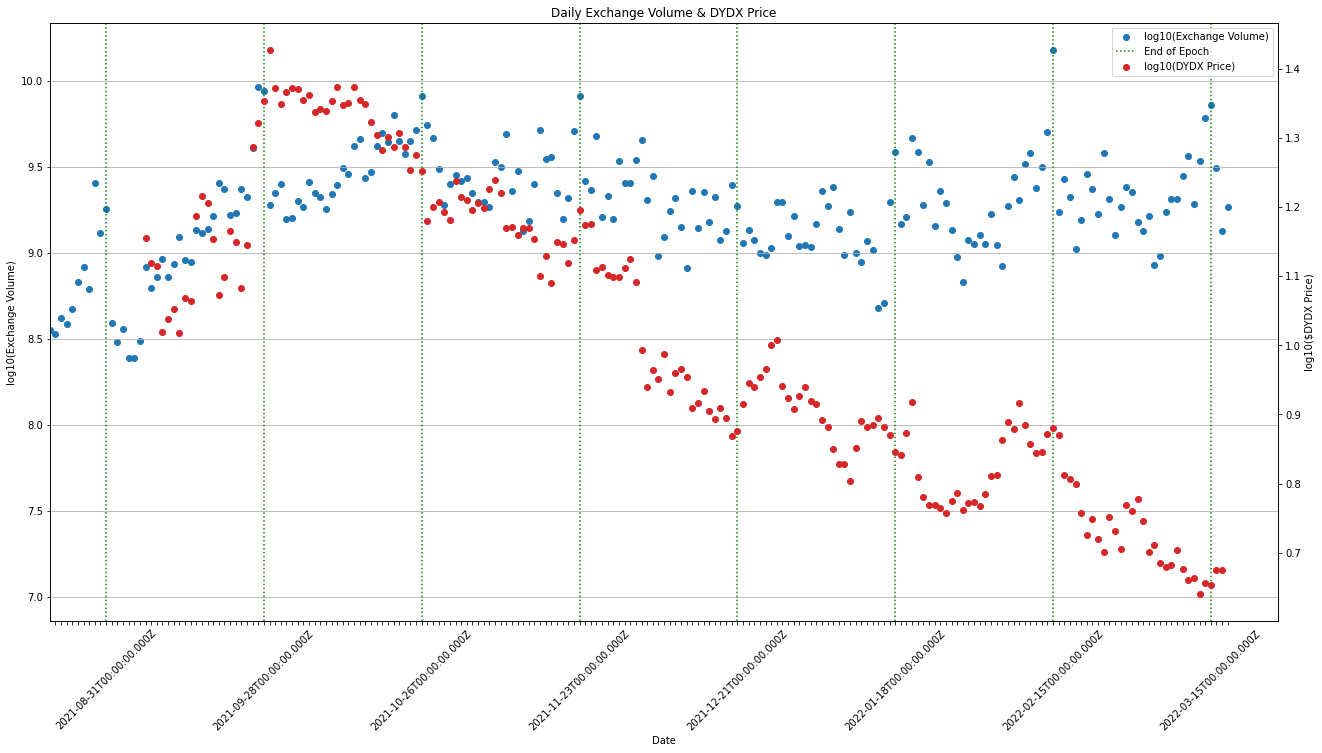

In [163]:
import matplotlib.pyplot as plt
import numpy as np

# get data
plot_set = daily_cumulative_volumes

# plot it
_, (ax) = plt.subplots(1, figsize=(22,11))

volumes_plot = ax.scatter(plot_set.index, np.log10(plot_set.values), label="log10(Exchange Volume)", color="tab:blue")

plt.title("Daily Exchange Volume & DYDX Price")
ax.set_xlabel("Date")
ax.set_ylabel("log10(Exchange Volume)")

epoch_end_dates = [
    "2021-08-31T00:00:00.000Z", # end of 0
    "2021-09-28T00:00:00.000Z", # end of 1
    "2021-10-26T00:00:00.000Z", # end of 2
    "2021-11-23T00:00:00.000Z", # end of 3
    "2021-12-21T00:00:00.000Z", # end of 4
    "2022-01-18T00:00:00.000Z", # end of 5
    "2022-02-15T00:00:00.000Z", # end of 6
    "2022-03-15T00:00:00.000Z", # end of 7
]
for epoch_end in epoch_end_dates:
    epoch_end_line = ax.axvline(x=epoch_end, color='g', linestyle=':', label="End of Epoch")

xticks = ax.xaxis.get_major_ticks()
for i, xtick in enumerate(xticks):
#     if i % 5 != 0:
    if plot_set.index[i] not in epoch_end_dates:
        xtick.label1.set_visible(False)
        
        
plt.xticks(rotation=45)
plt.grid(axis="y")
# ax.legend([epoch_end_line, volumes_plot], ['epoch end', 'log-volumes'], loc='upper left')


# Plot price
plot_set_prices = dydx_prices_series.reindex(daily_cumulative_volumes.index)
ax2 = ax.twinx()
ax2.set_ylabel("log10($DYDX Price)")
dydx_prices_plot = ax2.scatter(plot_set.index, np.log10(plot_set_prices.values), label="log10(DYDX Price)", color="tab:red")

# Add legend
lns = [volumes_plot, epoch_end_line, dydx_prices_plot]
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper right");


In [143]:
def get_log_diff(s):
    return s.rolling(2).apply(lambda v: np.log(v[1]/v[0]))

dydx_daily_log_diff = get_log_diff(dydx_prices_series); dydx_daily_log_diff

2021-09-07T00:00:00.000Z         NaN
2021-09-08T00:00:00.000Z   -0.082374
2021-09-09T00:00:00.000Z   -0.009015
2021-09-10T00:00:00.000Z   -0.221687
2021-09-11T00:00:00.000Z    0.046050
                              ...   
2022-03-13T00:00:00.000Z   -0.052550
2022-03-14T00:00:00.000Z    0.035927
2022-03-15T00:00:00.000Z   -0.006861
2022-03-16T00:00:00.000Z    0.050871
2022-03-17T00:00:00.000Z   -0.001690
Length: 192, dtype: float64

In [142]:
exchange_daily_log_diff = get_log_diff(daily_cumulative_volumes.reindex(dydx_daily_log_returns.index))
exchange_daily_log_diff

2021-09-07T00:00:00.000Z         NaN
2021-09-08T00:00:00.000Z   -0.282073
2021-09-09T00:00:00.000Z    0.143847
2021-09-10T00:00:00.000Z    0.248638
2021-09-11T00:00:00.000Z   -0.242543
                              ...   
2022-03-13T00:00:00.000Z    0.570874
2022-03-14T00:00:00.000Z    0.576548
2022-03-15T00:00:00.000Z    0.184098
2022-03-16T00:00:00.000Z   -0.850832
2022-03-17T00:00:00.000Z   -0.838167
Length: 192, dtype: float64

In [146]:
daily_diffs = pd.DataFrame({"dPrice": dydx_daily_log_diff, "dVol": exchange_daily_log_diff}).dropna(); daily_diffs

,dPrice,dVol
2021-09-08T00:00:00.000Z,-0.082374,-0.282073
2021-09-09T00:00:00.000Z,-0.009015,0.143847
2021-09-10T00:00:00.000Z,-0.221687,0.248638
2021-09-11T00:00:00.000Z,0.046050,-0.242543
2021-09-12T00:00:00.000Z,0.033108,0.178303
...,...,...
2022-03-13T00:00:00.000Z,-0.052550,0.570874
2022-03-14T00:00:00.000Z,0.035927,0.576548
2022-03-15T00:00:00.000Z,-0.006861,0.184098
2022-03-16T00:00:00.000Z,0.050871,-0.850832


In [154]:
np.corrcoef(
    daily_diffs.iloc[:,0] / daily_diffs.iloc[:,0].var(),
    daily_diffs.iloc[:,1] / daily_diffs.iloc[:,1].var()
)

array([[ 1.        , -0.11519594],
       [-0.11519594,  1.        ]])